Part 1: Install Required Dependencies

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Remove non-image files

In [4]:
import cv2
import imghdr

In [5]:
data_dir = "data"

In [6]:
image_exts = ["jpeg", "jpg", "bmp", "png"]

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print("Removing non-image file: {}".format(image_path))
                os.remove(image_path)

        except Exception as e:
            print("Issue with image {}: {}".format(image_path, str(e)))

Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory("data")

Found 1194 files belonging to 2 classes.


In [10]:
data_iterator = iter(data)


In [11]:
batch = next(data_iterator)

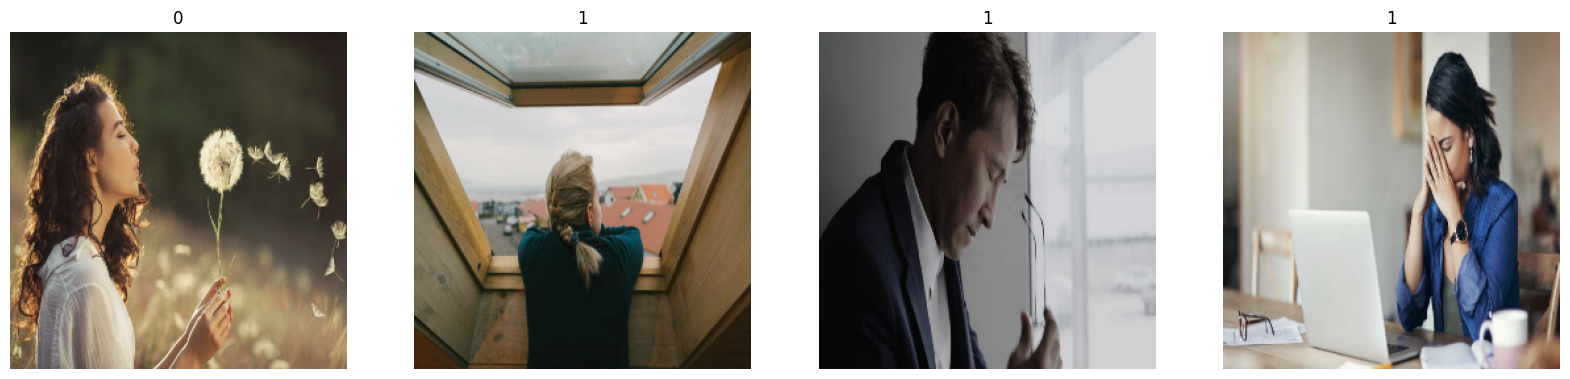

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(tf.squeeze(img).numpy().astype(np.uint8))
    ax[idx].set_title(batch[1][idx].numpy())
    ax[idx].axis("off")

plt.show()


Part 2: Preprocessing data

Scaling data

In [13]:
scaled_Data = data.map(lambda x, y: (x/255, y))
scaled_iterator = scaled_Data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()

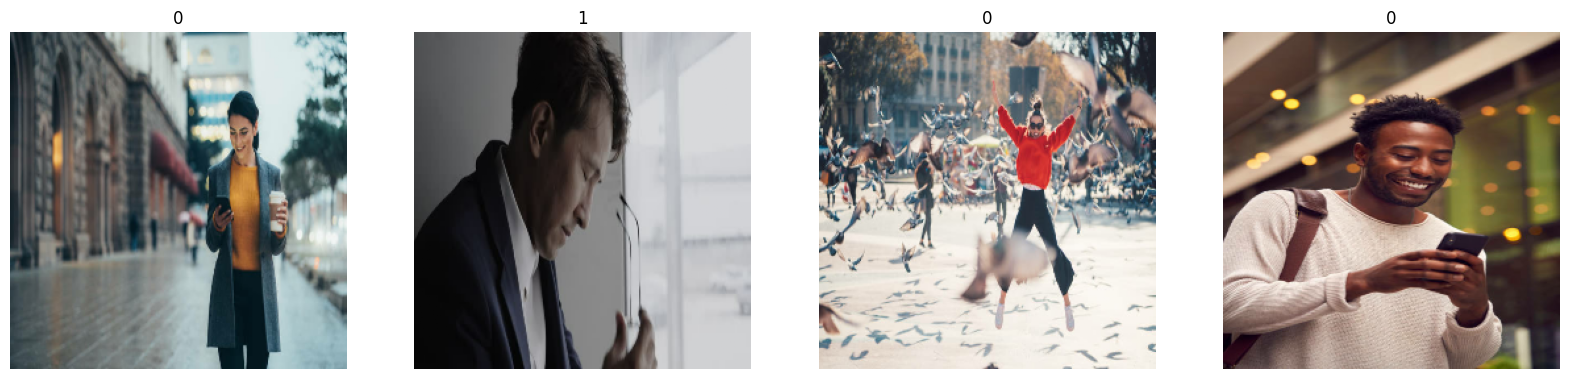

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(scaled_batch[1][idx])
    ax[idx].axis("off")

plt.show()

Split data

In [15]:
train_size = int(len(scaled_Data)*.7)
val_size = int(len(scaled_Data)*.2)+1
test_size = int(len(scaled_Data)*.1)

In [16]:
train = scaled_Data.take(train_size)
val = scaled_Data.skip(train_size).take(val_size)
test = scaled_Data.skip(train_size+val_size).take(test_size)

Part 3: Deep modelling

Build deep learing model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


C:\Users\GR DESAI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Build the model
model.build(input_shape=(None, 256, 256, 3))

In [21]:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [23]:
logdir = "logs"

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 702ms/step - accuracy: 0.4819 - loss: 1.1520 - val_accuracy: 0.5625 - val_loss: 0.6850
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 885ms/step - accuracy: 0.6032 - loss: 0.6829 - val_accuracy: 0.6211 - val_loss: 0.6777
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 781ms/step - accuracy: 0.6561 - loss: 0.6704 - val_accuracy: 0.6211 - val_loss: 0.6345
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 798ms/step - accuracy: 0.6712 - loss: 0.6187 - val_accuracy: 0.6562 - val_loss: 0.6155
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 693ms/step - accuracy: 0.7117 - loss: 0.5822 - val_accuracy: 0.7148 - val_loss: 0.6087
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7438 - loss: 0.5753 - val_accuracy: 0.6992 - val_loss: 0.6109
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7164 - loss: 0.5551 - val_accuracy: 0.6250 - val_loss: 0.6704
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 883ms/step - accuracy: 0.7588 - loss: 0.5205 - val_accuracy: 

Plot Performance

In [26]:
hist.history

{'accuracy': [0.5216346383094788,
  0.578125,
  0.6322115659713745,
  0.6574519276618958,
  0.6947115659713745,
  0.7199519276618958,
  0.7307692170143127,
  0.7692307829856873,
  0.801682710647583,
  0.864182710647583,
  0.9134615659713745,
  0.9411057829856873,
  0.9615384340286255,
  0.984375,
  0.984375,
  0.989182710647583,
  0.9963942170143127,
  0.9939903616905212,
  0.9927884340286255,
  0.995192289352417],
 'loss': [0.8649565577507019,
  0.6802361607551575,
  0.6606607437133789,
  0.6230389475822449,
  0.5839256644248962,
  0.5708568096160889,
  0.5478244423866272,
  0.5068278908729553,
  0.4017547369003296,
  0.3233495056629181,
  0.24241915345191956,
  0.1614457070827484,
  0.1159064769744873,
  0.09666182100772858,
  0.0774804875254631,
  0.03745879605412483,
  0.016705909743905067,
  0.03638915717601776,
  0.023683318868279457,
  0.03155706822872162],
 'val_accuracy': [0.5625,
  0.62109375,
  0.62109375,
  0.65625,
  0.71484375,
  0.69921875,
  0.625,
  0.69921875,
  0.738

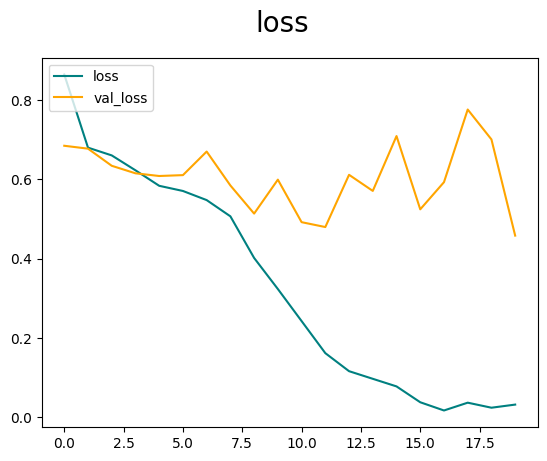

In [27]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

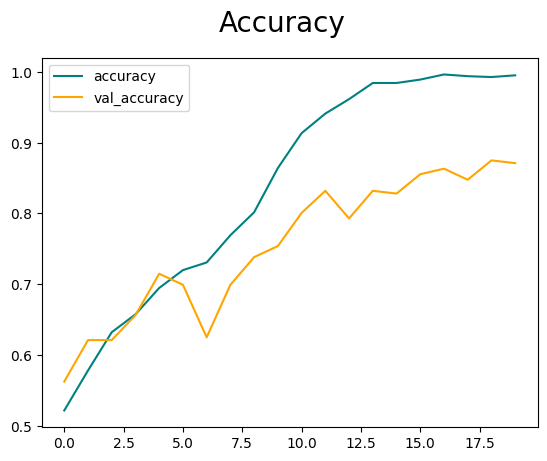

In [28]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

Part 4: Evaluvating Performance

Evavulate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
len(test)

3

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for temp_batch in test.as_numpy_iterator():
    x, y = temp_batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


In [33]:
print(f"Precision: {pre.result().numpy()}   Recall: {re.result().numpy()}   Accuracy: {acc.result().numpy()}")

Precision: 0.8823529481887817   Recall: 0.8823529481887817   Accuracy: 0.875


Test

In [34]:
import cv2

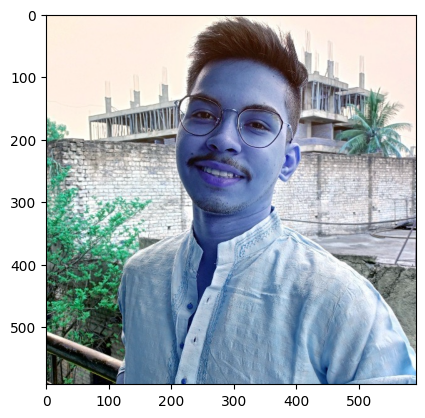

In [45]:
img = cv2.imread("happytest.jpeg")
plt.imshow(img)
plt.show()

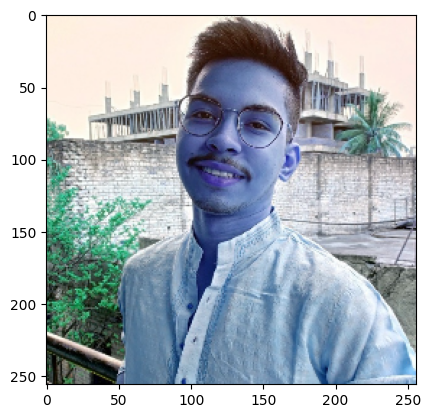

In [46]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


In [48]:
yhat

array([[0.06960265]], dtype=float32)

In [49]:
if yhat < 0.5:
    print("The person shown in the image is happy!")
else:
    print("The person shown in the image is sad!")

The person shown in the image is happy!


Part 5:Save the model

Save the model

In [53]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join("models", "happy_sad_model.h5"))

In [54]:
new_model = load_model(os.path.join("models", "happy_sad_model.h5"))

In [55]:
new_yhat = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


In [56]:
if new_yhat < 0.5:
    print("The person shown in the image is happy!")
else:
    print("The person shown in the image is sad!")

The person shown in the image is happy!
